In [21]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch.optim import Adam

In [22]:
torch.manual_seed(42)
BATCH_SIZE= 32
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset= MNIST(root= './data', train= True, download= True, transform= transform)
test_dataset= MNIST(root= './data', train= False, download= True, transform= transform)
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

In [23]:
len(train_dataset), len(test_dataset)

(60000, 10000)

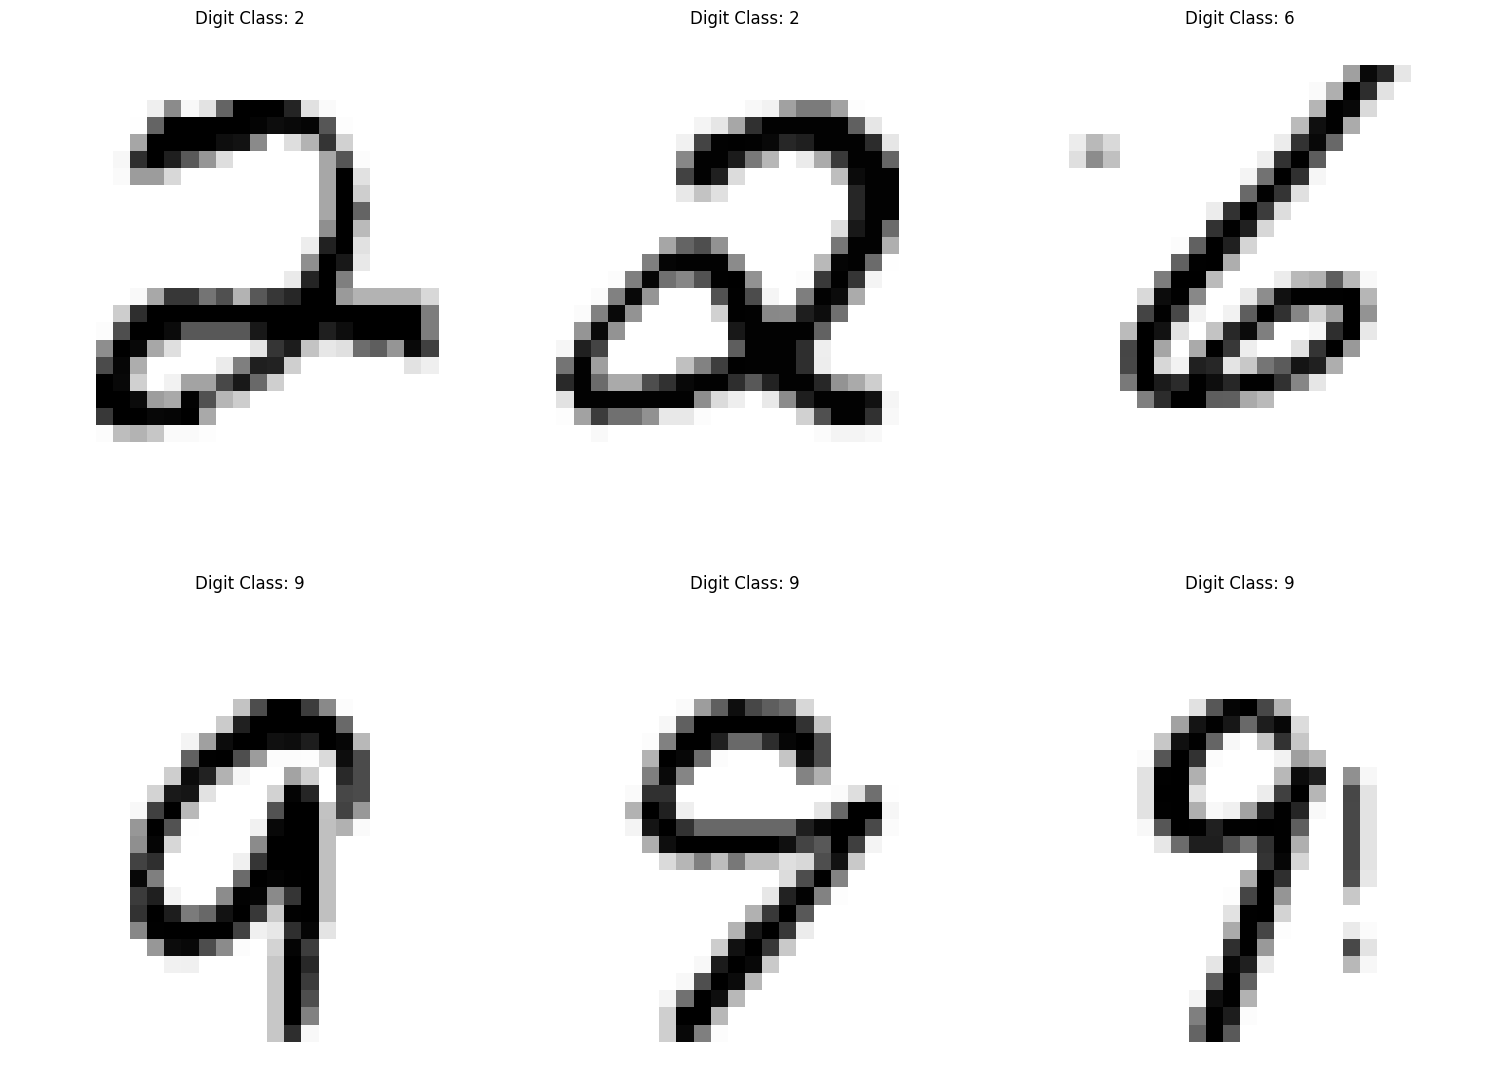

In [24]:
def display_images(images, labels, indices, n_rows= 2, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze(), cmap= plt.cm.binary)
        axes[i].axis(False)
        axes[i].set_title(f"Digit Class: {label}")
    plt.tight_layout()
    plt.show()

images, labels= next(iter(train_loader))
indices= [1, 4, 5, 6, 7, 8]
display_images(images, labels, indices)

In [25]:
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 256) # Input Shape: 28x28= 784, Out Shape: 256
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(256, 128) # Input Shape: 256, Out Shape: 128
        self.relu2= nn.ReLU()


        self.output= nn.Linear(128, 10) # In Shape: 128, Outshape: num classes = 10

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits


In [26]:
torch.manual_seed(42)
model= TinyMLP()

LEARNING_RATE= 0.008
NUM_EPOCHS= 15

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_fn= nn.CrossEntropyLoss()
optimizer= Adam(model.parameters(), lr= LEARNING_RATE)

train_loss_history= []
val_loss_history= []
train_acc_history= []
val_acc_history= []

patience= 3
epochs_without_improvement= 0
min_delta= 0.001
best_val_loss= 0.5

for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss= 0.0
    train_correct= 0.0
    train_total= 0.0

    for images, labels in train_loader:
        images, labels= images.to(device), labels.to(device)
        preds= model(images)
        loss= loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss+= loss

        # Calculate Training Accuracy
        _, predicted= torch.max(preds.data, 1)
        train_total+= labels.size(0)
        train_correct+= (predicted == labels).sum().item()

    model.eval()
    running_val_loss= 0.0
    val_correct= 0.0
    val_total= 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            preds= model(images)
            loss= loss_fn(preds, labels)

            running_val_loss+= loss

            # Calculate Val Accuracy
            _, predicted= torch.max(preds.data, 1)
            val_total+= labels.size(0)
            val_correct+= (predicted == labels).sum().item()

        if loss < best_val_loss - min_delta:
            best_val_loss= loss
            epochs_without_improvement= 0
        else:
            epochs_without_improvement+= 1

    running_val_loss/= len(test_loader)
    running_train_loss/= len(train_loader)

    train_acc= (train_correct / train_total) * 100
    val_acc= (val_correct / val_total) * 100

    train_loss_history.append(running_train_loss.item())
    val_loss_history.append(running_val_loss.item())
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} ")
    print("-" * 10)
    print(f"Train Loss: {running_train_loss.item():.4f}")
    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {running_val_loss.item():.4f}")
    print(f"Val Accuracy: {val_acc:.2f}%")
    print("-" * 50)

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement after {patience} epochs.")
        break


Epoch 1/15 
----------
Train Loss: 0.2597
Train Accuracy: 92.40%
Val Loss: 0.1661
Val Accuracy: 95.25%
--------------------------------------------------
Epoch 2/15 
----------
Train Loss: 0.1603
Train Accuracy: 95.58%
Val Loss: 0.1559
Val Accuracy: 95.70%
--------------------------------------------------
Epoch 3/15 
----------
Train Loss: 0.1378
Train Accuracy: 96.27%
Val Loss: 0.1789
Val Accuracy: 95.89%
--------------------------------------------------
Epoch 4/15 
----------
Train Loss: 0.1263
Train Accuracy: 96.74%
Val Loss: 0.1738
Val Accuracy: 96.07%
--------------------------------------------------
Epoch 5/15 
----------
Train Loss: 0.1132
Train Accuracy: 97.11%
Val Loss: 0.1649
Val Accuracy: 96.24%
--------------------------------------------------
Epoch 6/15 
----------
Train Loss: 0.1013
Train Accuracy: 97.48%
Val Loss: 0.1337
Val Accuracy: 97.04%
--------------------------------------------------
Early stopping triggered at epoch 6. No improvement after 3 epochs.


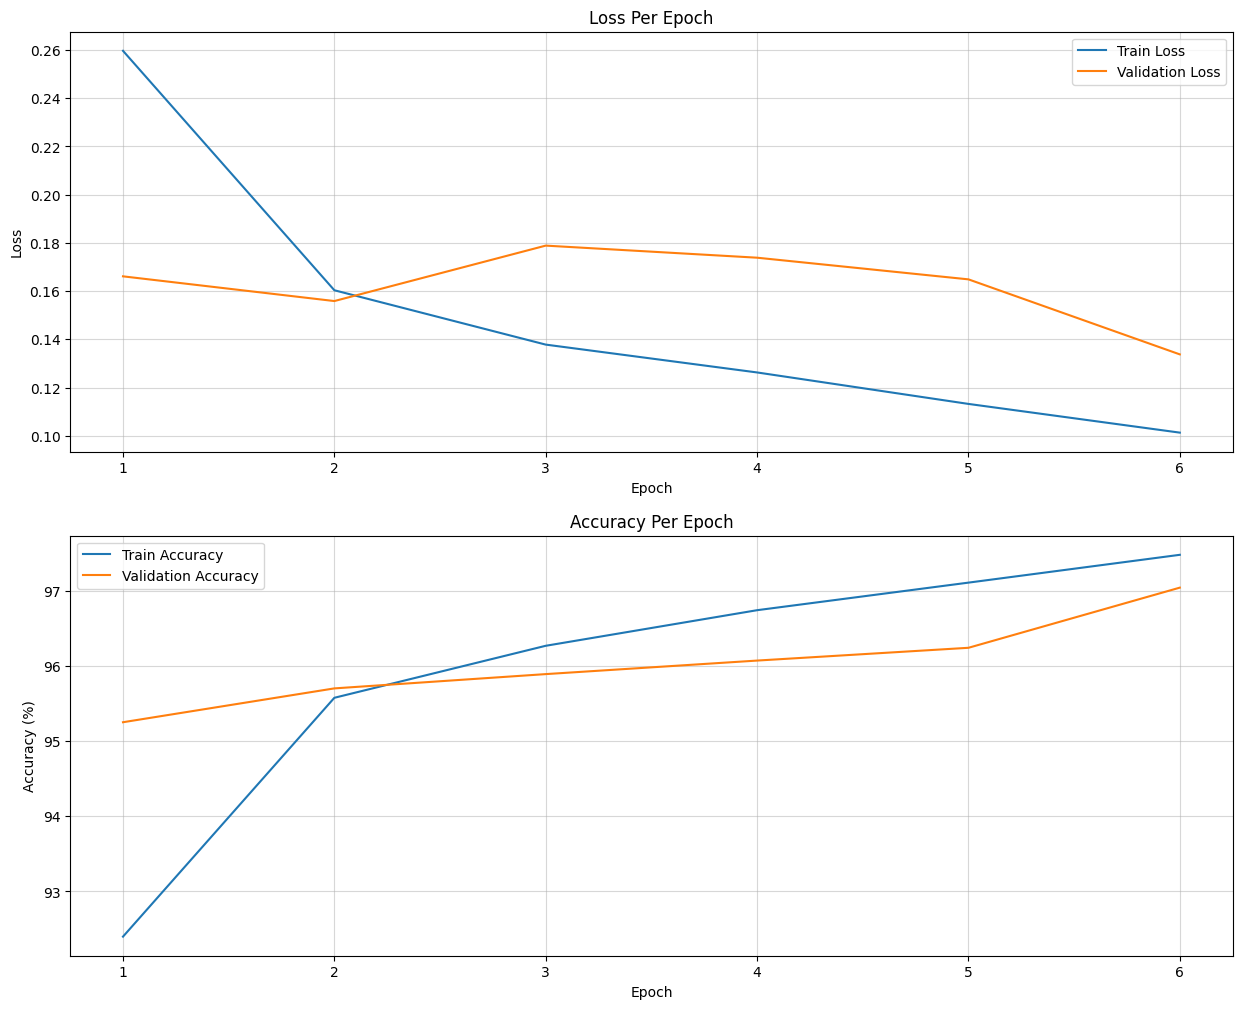

In [27]:
epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
fig= plt.figure(figsize= (15, 12))

ax1= fig.add_subplot(211)
ax1.set_title("Loss Per Epoch")
ax1.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
p1= ax1.plot(epochs, train_loss_history)
p2= ax1.plot(epochs, val_loss_history)
ax1.legend((p1[0], p2[0]), ('Train Loss', 'Validation Loss'))

ax2= fig.add_subplot(212)
ax2.set_title("Accuracy Per Epoch")
ax2.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
p2= ax2.plot(epochs, train_acc_history)
p3= ax2.plot(epochs, val_acc_history)
ax2.legend((p2[0], p3[0]), ('Train Accuracy', 'Validation Accuracy'))
plt.grid(True)